<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Bangla_Accent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies and importing libraries

In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import resampy

## Importing metadata to access audio files

In [4]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/metadata.csv')

In [5]:
metadata.head()

,file_name,folder_name,accent
0,barishal_audio_01.wav,barishal,barishal
1,barishal_audio_02.wav,barishal,barishal
2,barishal_audio_03.wav,barishal,barishal
3,barishal_audio_04.wav,barishal,barishal
4,barishal_audio_05.wav,barishal,barishal


In [6]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
523,puran_dhaka_audio_86.wav,puran dhaka,puran dhaka
250,chottgram_audio_50.wav,chottogram,chottogram
428,pabna_audio_03.wav,pabna,pabna
228,chottgram_audio_28.wav,chottogram,chottogram
208,chottgram_audio_09.wav,chottogram,chottogram


In [7]:
len(metadata)

635

## EDA of random audio file

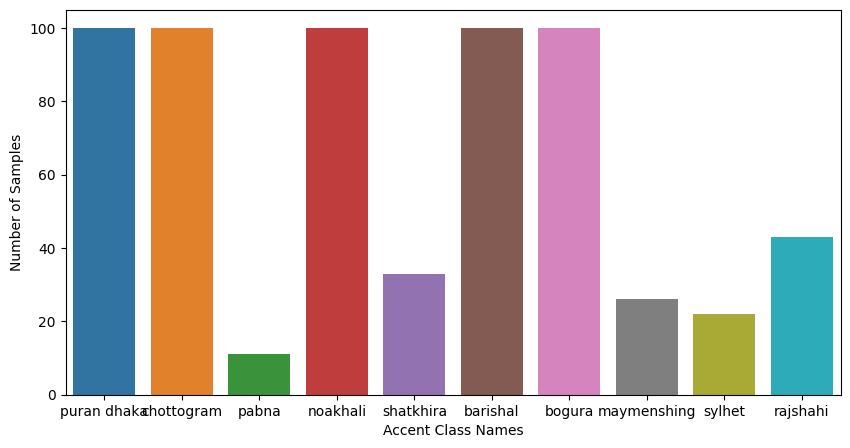

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x=metadata['accent'], ax=ax)
plt.xlabel('Accent Class Names')
plt.ylabel('Number of Samples')
plt.show()

In [9]:
import librosa
import librosa.display

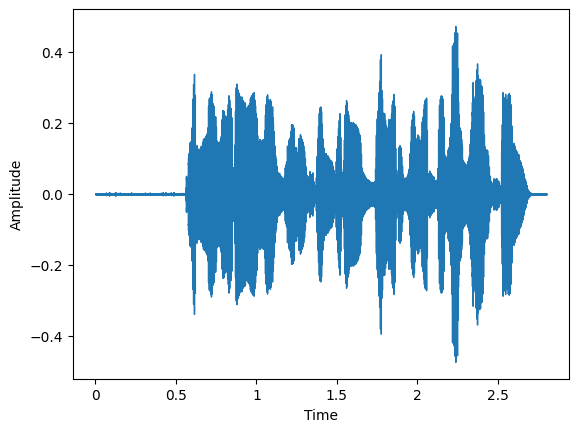

In [10]:
audio_file = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/barishal/barishal_audio_01.wav'
signal, sr = librosa.load(audio_file, res_type='kaiser_fast')
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

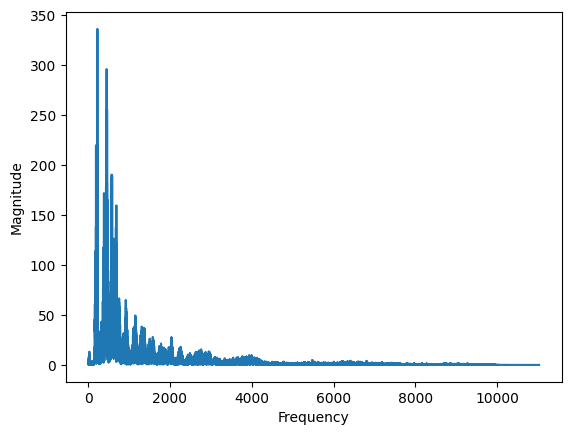

In [11]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# we have wsed forier transformation to exclude the mirror effect on the data.
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# we can see that most of the energy is concentrated on the lower frequencies and the less energy liaes in the middle range frequency.

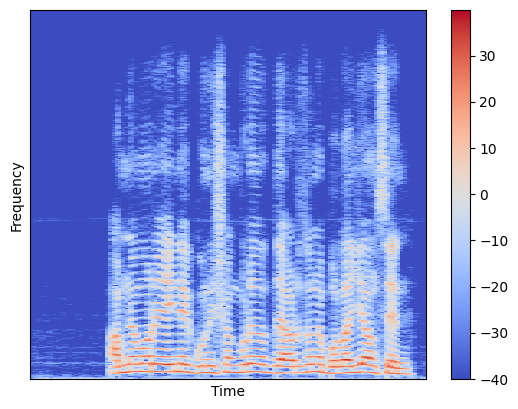

In [12]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

# Through spectrogram analysis we can see that it also states that the most of the energy consists in the lower frequency.
# The spectrogram remains stable through out time.

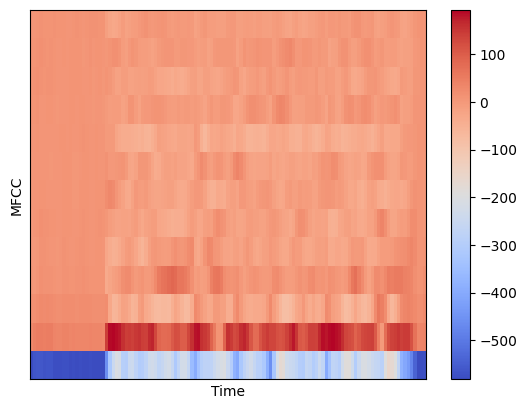

In [13]:
# finding mfcc

MFCCs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

librosa.display.specshow(MFCCs)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# This is the plot showing the MFCCs over time. There are 13 intervals in this spectrogram. The inteval represents the coffecients.
# We basically seeing here that how different MFCCs evolving over time.

## Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [14]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features


In [15]:
# collecting features for all the audio files

from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

635it [04:13,  2.51it/s]


In [16]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-341.5201, 103.83371, -28.929796, 1.8055182, ...",puran dhaka
1,"[-332.8591, 132.5588, -12.289821, 29.559639, -...",chottogram
2,"[-345.72644, 81.16386, -21.98971, 15.016742, -...",pabna
3,"[-332.63058, 120.516426, -13.524564, 30.3945, ...",chottogram
4,"[-283.31747, 99.24094, -44.311, 16.308073, -18...",chottogram


## Creating train and test data

In [17]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [18]:
X.shape

(635, 40)

In [19]:
y.shape

(635,)

### Applying OneHot encoding for the accent classes

In [20]:
# OneHot Encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y = encoder.fit_transform((extracted_features_df['class'].to_numpy()).reshape(-1,1))

In [21]:
y.shape

(635, 10)

In [22]:
y = y.toarray()

### Spliting features into training and test set

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [24]:
X_train

array([[-1.9580597e+02,  1.1105014e+02, -2.5994461e+01, ...,
        -3.2107491e+00,  1.9761004e-01, -1.2425516e+00],
       [-3.6218338e+02,  9.4152748e+01, -4.2699760e+01, ...,
         2.0163352e+00,  2.7184532e+00,  2.1950438e+00],
       [-3.3245471e+02,  1.1661169e+02, -1.3507071e+01, ...,
         8.7147636e+00,  1.3976165e+01,  9.8600750e+00],
       ...,
       [-3.6281360e+02,  1.0318124e+02, -3.1072701e+01, ...,
         2.5868177e+00,  4.5365515e+00,  2.0768409e+00],
       [-3.1822504e+02,  1.4393381e+02, -3.2202961e+01, ...,
        -6.3845568e+00, -3.1093292e+00,  1.4907378e+00],
       [-3.3033615e+02,  1.4143086e+02, -5.9780061e-01, ...,
        -3.8449463e-01,  1.0971119e+00, -9.0789646e-01]], dtype=float32)

In [25]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
X_train.shape

(508, 40)

In [27]:
y_train.shape

(508, 10)

## Building ANN model

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

In [29]:
y.shape[1]

10

In [53]:
# No of classes
num_labels=y.shape[1]

In [58]:
model=Sequential()
# first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# third layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# fourth layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 100)               4100      
                                                                 
 activation_25 (Activation)  (None, 100)               0         
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 200)               20200     
                                                                 
 activation_26 (Activation)  (None, 200)               0         
                                                                 
 dropout_20 (Dropout)        (None, 200)               0         
                                                                 
 dense_27 (Dense)            (None, 200)              

In [60]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.optimizers.Adam())

In [61]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience = 20,
                                              restore_best_weights = True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
16/16 [==============================] - 2s 17ms/step - loss: 18.8237 - accuracy: 0.1575 - val_loss: 4.4932 - val_accuracy: 0.1417
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 6.5596 - accuracy: 0.1457 - val_loss: 2.1687 - val_accuracy: 0.1417
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 4.1757 - accuracy: 0.1516 - val_loss: 2.1112 - val_accuracy: 0.1339
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 3.2775 - accuracy: 0.1339 - val_loss: 2.0963 - val_accuracy: 0.1969
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 2.8901 - accuracy: 0.1437 - val_loss: 2.1166 - val_accuracy: 0.1890
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 2.6142 - accuracy: 0.1634 - val_loss: 2.1346 - val_accuracy: 0.1654
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 2.5189 - accuracy: 0.1516 - val_loss: 2.1418 - val_accuracy: 0.1417
Epoch 8/100

In [62]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8110235929489136


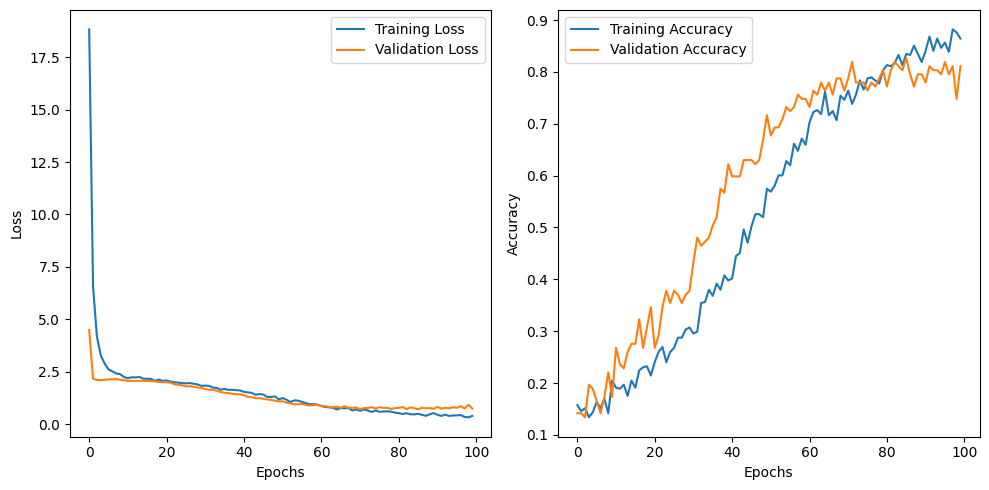

In [63]:
# Ploting history (also known as a loss curve or a training curve)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Making prediction and converting probability distribution into OneHot encoded vector

In [64]:
y_pred_ann = model.predict(X_test)

predictions_ann = []

for row in y_pred_ann:
  label = np.zeros(num_labels)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_ann.append(label.tolist())
  label = None

4/4 [==============================] - 0s 3ms/step


In [65]:
y_test_for_eval = encoder.inverse_transform(y_test)
predictions_ann = encoder.inverse_transform(predictions_ann)

In [66]:
print(predictions_ann)

[['puran dhaka']
 ['puran dhaka']
 ['noakhali']
 ['puran dhaka']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['chottogram']
 ['puran dhaka']
 ['maymenshing']
 ['bogura']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['chottogram']
 ['puran dhaka']
 ['chottogram']
 ['noakhali']
 ['barishal']
 ['chottogram']
 ['rajshahi']
 ['chottogram']
 ['noakhali']
 ['chottogram']
 ['noakhali']
 ['rajshahi']
 ['shatkhira']
 ['bogura']
 ['puran dhaka']
 ['chottogram']
 ['maymenshing']
 ['chottogram']
 ['noakhali']
 ['bogura']
 ['bogura']
 ['chottogram']
 ['bogura']
 ['puran dhaka']
 ['bogura']
 ['maymenshing']
 ['noakhali']
 ['noakhali']
 ['barishal']
 ['rajshahi']
 ['shatkhira']
 ['maymenshing']
 ['noakhali']
 ['maymenshing']
 ['shatkhira']
 ['puran dhaka']
 ['barishal']
 ['barishal']
 ['chottogram']
 ['shatkhira']
 ['bogura']
 ['puran dhaka']
 ['noakhali']
 ['puran dhaka']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['barishal']
 ['maymenshing']
 ['bogura']
 [

### Finding Evaluation parameters

In [67]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [68]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_ann))
print('Precision score: ', precision_score(y_test_for_eval, predictions_ann, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_ann, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_ann, average='weighted'))

Accuracy score :  0.8110236220472441
Precision score:  0.808906098276177
Recall score   :  0.8110236220472441
F1 Score       :  0.8032177377310706


In [69]:
print(classification_report(y_test_for_eval, predictions_ann))

              precision    recall  f1-score   support

    barishal       0.92      0.80      0.86        15
      bogura       0.79      0.92      0.85        24
  chottogram       0.75      0.72      0.73        25
 maymenshing       1.00      1.00      1.00         9
    noakhali       0.84      0.84      0.84        19
       pabna       0.67      1.00      0.80         2
 puran dhaka       0.78      0.88      0.82        16
    rajshahi       0.25      0.17      0.20         6
   shatkhira       1.00      1.00      1.00         8
      sylhet       1.00      0.33      0.50         3

    accuracy                           0.81       127
   macro avg       0.80      0.77      0.76       127
weighted avg       0.81      0.81      0.80       127



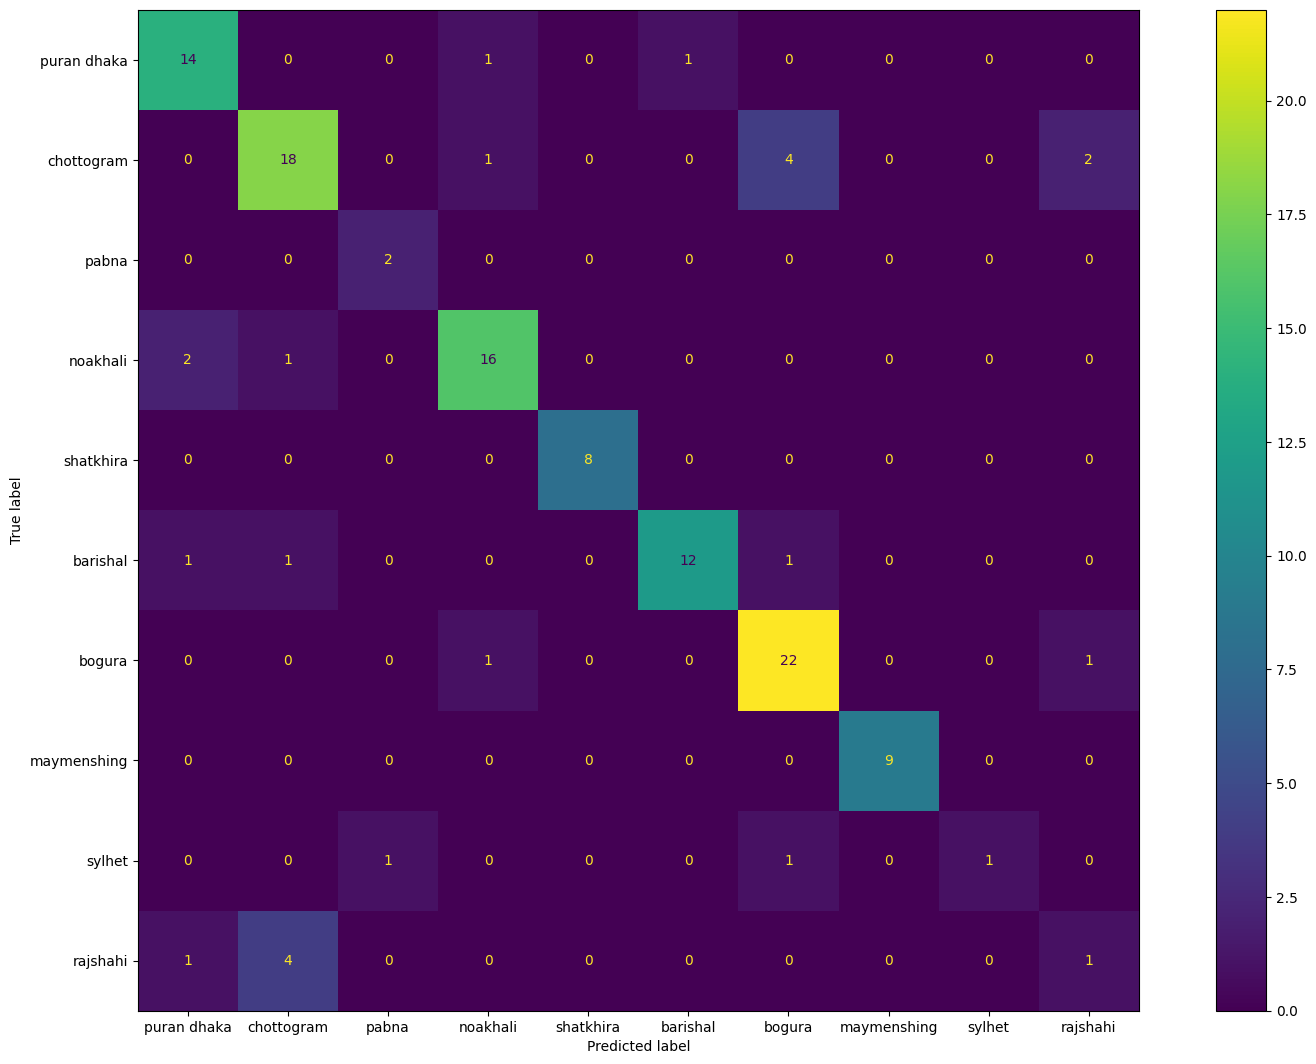

In [70]:
cm = confusion_matrix(y_test_for_eval, predictions_ann, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(20,13))
disp.plot(ax=ax)
plt.show()

## Building LSTM model

In [71]:
from tensorflow.keras.layers import LSTM

In [75]:
model = tf.keras.Sequential()
# first layer after input layer
model.add(LSTM(100,input_shape=(40,1)))
model.add(Dropout(0.2))
# second layer
model.add(Dense(100, activation='relu'))
# third layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
# forth layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_26 (Dropout)        (None, 100)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                                 
 dense_35 (Dense)            (None, 100)               10100     
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_36 (Dense)            (None, 100)               10100     
                                                                 
 dropout_28 (Dropout)        (None, 100)              

In [76]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [77]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience = 25,
                                              restore_best_weights = True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_test, y_test))

Epoch 1/100
16/16 [==============================] - 5s 63ms/step - loss: 2.2639 - accuracy: 0.1496 - val_loss: 2.1843 - val_accuracy: 0.1969
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 2.1372 - accuracy: 0.1909 - val_loss: 2.0698 - val_accuracy: 0.2283
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 2.0339 - accuracy: 0.2224 - val_loss: 2.0089 - val_accuracy: 0.2126
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 2.0089 - accuracy: 0.2165 - val_loss: 1.9402 - val_accuracy: 0.3071
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 1.9374 - accuracy: 0.2638 - val_loss: 1.8338 - val_accuracy: 0.3465
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 1.8545 - accuracy: 0.3012 - val_loss: 1.7951 - val_accuracy: 0.4252
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 1.7941 - accuracy: 0.3169 - val_loss: 1.7316 - val_accuracy: 0.4331
Epoch 

In [78]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5905511975288391


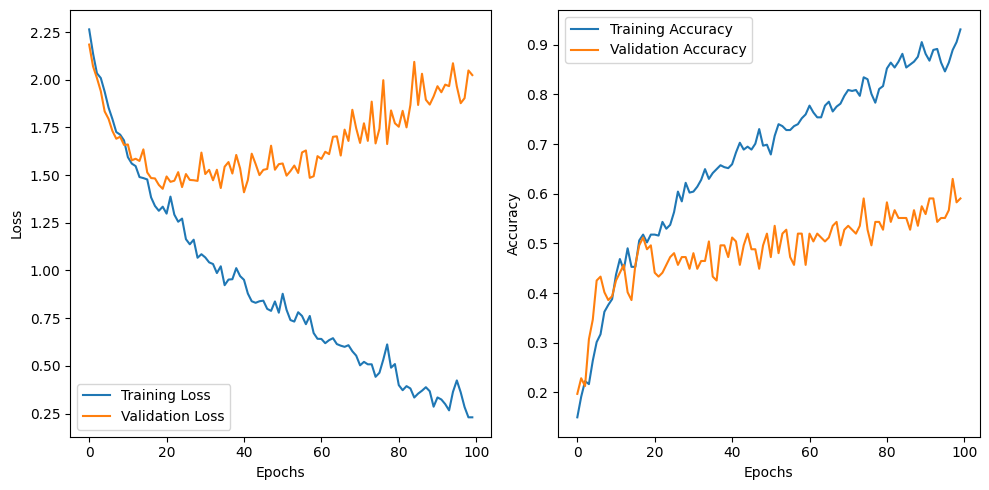

In [79]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Making predictions into OneHot encoded format and converting it into real classs names

In [81]:
y_pred_lstm = model.predict(X_test)

predictions_lstm = []

for row in y_pred_lstm:
  label = np.zeros(num_labels)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_lstm.append(label.tolist())
  label = None

4/4 [==============================] - 0s 6ms/step


In [82]:
predictions_lstm = encoder.inverse_transform(predictions_lstm)

In [83]:
print(predictions_lstm)

[['puran dhaka']
 ['puran dhaka']
 ['noakhali']
 ['puran dhaka']
 ['bogura']
 ['puran dhaka']
 ['noakhali']
 ['rajshahi']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['chottogram']
 ['puran dhaka']
 ['maymenshing']
 ['barishal']
 ['noakhali']
 ['bogura']
 ['barishal']
 ['chottogram']
 ['bogura']
 ['rajshahi']
 ['noakhali']
 ['barishal']
 ['shatkhira']
 ['rajshahi']
 ['chottogram']
 ['noakhali']
 ['noakhali']
 ['shatkhira']
 ['noakhali']
 ['puran dhaka']
 ['puran dhaka']
 ['puran dhaka']
 ['chottogram']
 ['maymenshing']
 ['rajshahi']
 ['shatkhira']
 ['puran dhaka']
 ['noakhali']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['bogura']
 ['chottogram']
 ['rajshahi']
 ['noakhali']
 ['puran dhaka']
 ['noakhali']
 ['shatkhira']
 ['maymenshing']
 ['chottogram']
 ['maymenshing']
 ['bogura']
 ['barishal']
 ['barishal']
 ['barishal']
 ['shatkhira']
 ['puran dhaka']
 ['bogura']
 ['bogura']
 ['noakhali']
 ['puran dhaka']
 ['chottogram']
 ['bogura']
 ['bogura']
 ['barishal']
 ['maymenshing']
 ['chottogram']


### Finding evaluation parameters

In [84]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_lstm))
print('Precision score: ', precision_score(y_test_for_eval, predictions_lstm, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_lstm, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_lstm, average='weighted'))

Accuracy score :  0.5905511811023622
Precision score:  0.6145221152168813
Recall score   :  0.5905511811023622
F1 Score       :  0.5929485350916632


In [85]:
print(classification_report(y_test_for_eval, predictions_lstm))

              precision    recall  f1-score   support

    barishal       0.59      0.67      0.62        15
      bogura       0.73      0.67      0.70        24
  chottogram       0.67      0.40      0.50        25
 maymenshing       1.00      0.89      0.94         9
    noakhali       0.57      0.63      0.60        19
       pabna       1.00      1.00      1.00         2
 puran dhaka       0.48      0.62      0.54        16
    rajshahi       0.29      0.33      0.31         6
   shatkhira       0.36      0.50      0.42         8
      sylhet       0.33      0.33      0.33         3

    accuracy                           0.59       127
   macro avg       0.60      0.60      0.60       127
weighted avg       0.61      0.59      0.59       127



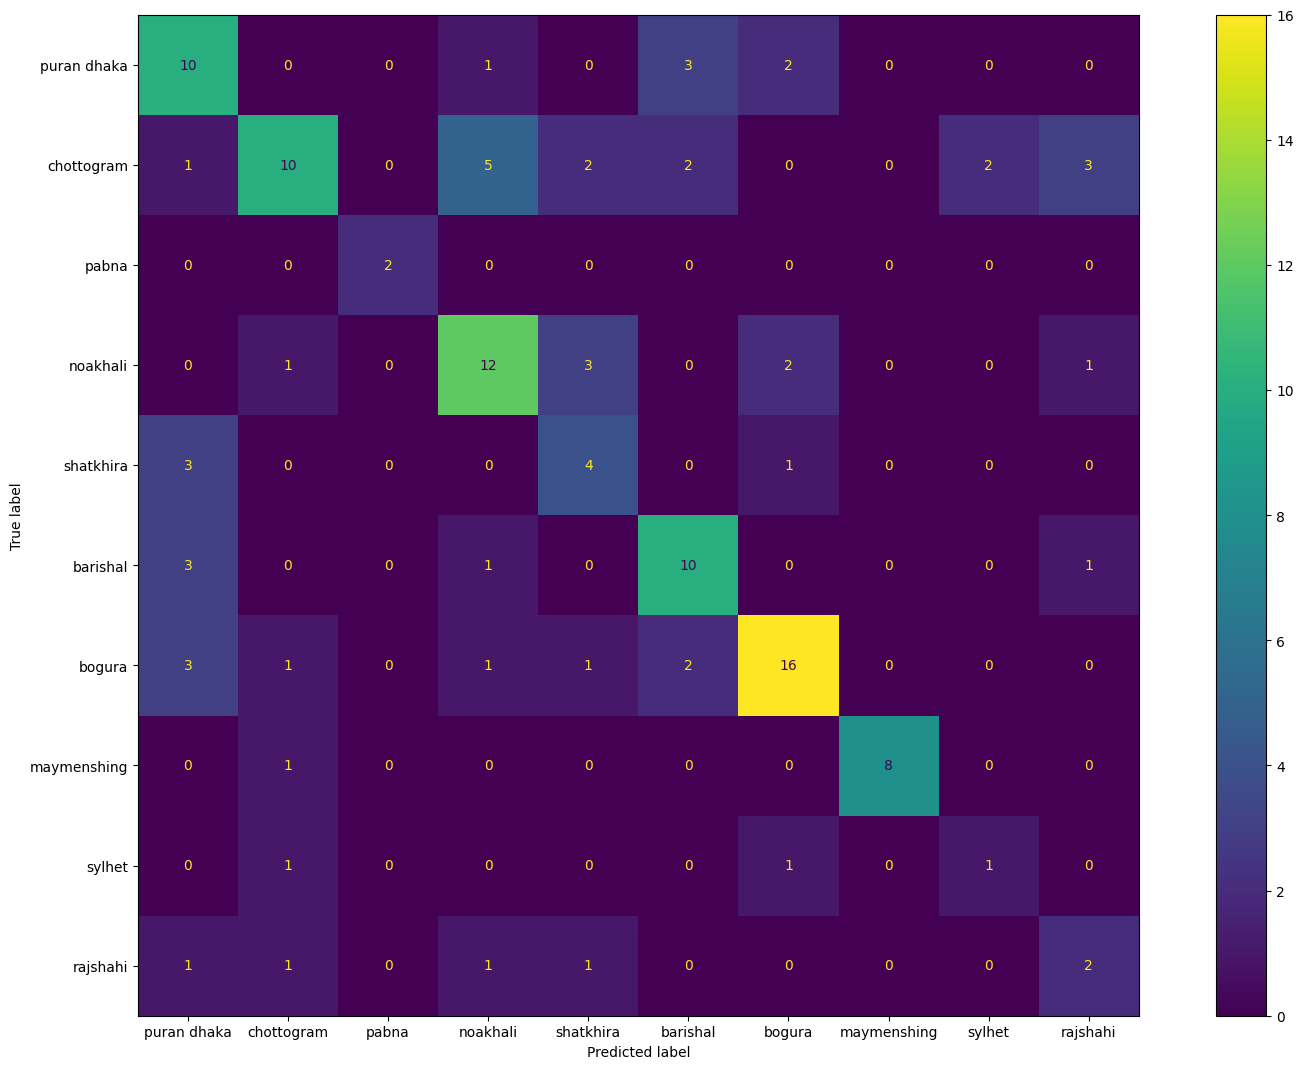

In [87]:
cm = confusion_matrix(y_test_for_eval, predictions_lstm, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(20,13))
disp.plot(ax=ax)
plt.show()